In [24]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torchvision.transforms as transforms


In [ ]:
Download images of beagles

In [ ]:

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for consistency
    transforms.ToTensor()
])

# Load the Oxford-IIIT Pets dataset with category labels
dataset = OxfordIIITPet(root='./data', split='trainval', target_types='category', transform=transform, download=True)

# Read the breed metadata from annotations/list.txt
breed_to_index = {}
image_to_breed = []

# Path to the metadata file
annotations_path = os.path.join('./data/oxford-iiit-pet', 'annotations', 'list.txt')

with open(annotations_path, 'r') as f:
    lines = f.readlines()[6:]  # Skip header lines
    for line in lines:
        parts = line.strip().split()
        filename = parts[0]
        breed = filename.split('_')[0]
        if breed not in breed_to_index:
            breed_to_index[breed] = len(breed_to_index)
        image_to_breed.append((filename, breed))

# Find the index for "Beagle" breed
beagle_breed = "beagle"
beagle_images = [i for i, (filename, breed) in enumerate(image_to_breed) if breed == beagle_breed]

# Create a subset of the dataset with only Beagle images
beagle_dataset = Subset(dataset, beagle_images)



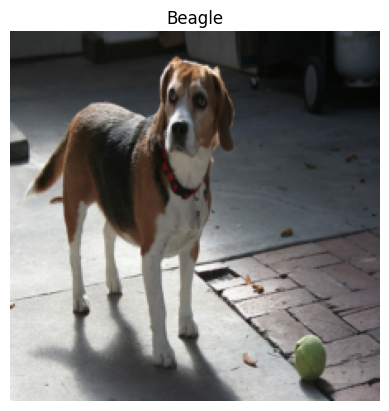

In [15]:
# Load and display one Beagle image
image, label = beagle_dataset[86]  # Get the first Beagle image

# Display the image
plt.imshow(image.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
plt.axis("off")
plt.title("Beagle")
plt.show()


Split into patches

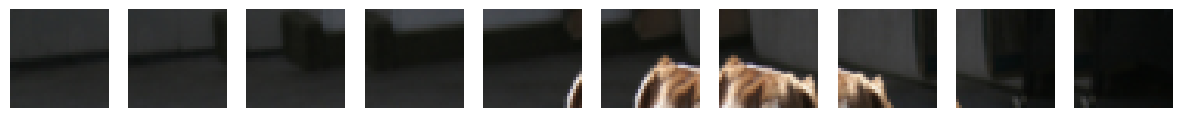

In [18]:
def extract_overlapping_patches(image_tensor, patch_size=32, stride=16, max_patches=100):
    """Extract overlapping patches from an image tensor, limited to a maximum number."""
    patches = []
    _, height, width = image_tensor.shape
    image_pil = transforms.ToPILImage()(image_tensor)  # Convert tensor to PIL Image for cropping
    
    # Loop to extract patches
    for y in range(0, height - patch_size + 1, stride):
        for x in range(0, width - patch_size + 1, stride):
            patch = image_pil.crop((x, y, x + patch_size, y + patch_size))
            patches.append(patch)
            
            # Stop if we reach the maximum number of patches
            if len(patches) >= max_patches:
                return patches
    return patches

# Extract up to 100 overlapping patches from the selected Beagle image
patch_size = 32
stride = 16
max_patches = 100
patches = extract_overlapping_patches(image, patch_size=patch_size, stride=stride, max_patches=max_patches)

# Display the patches to verify extraction
fig, axes = plt.subplots(1, min(len(patches), 10), figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(patches[i])
    ax.axis("off")
plt.show()


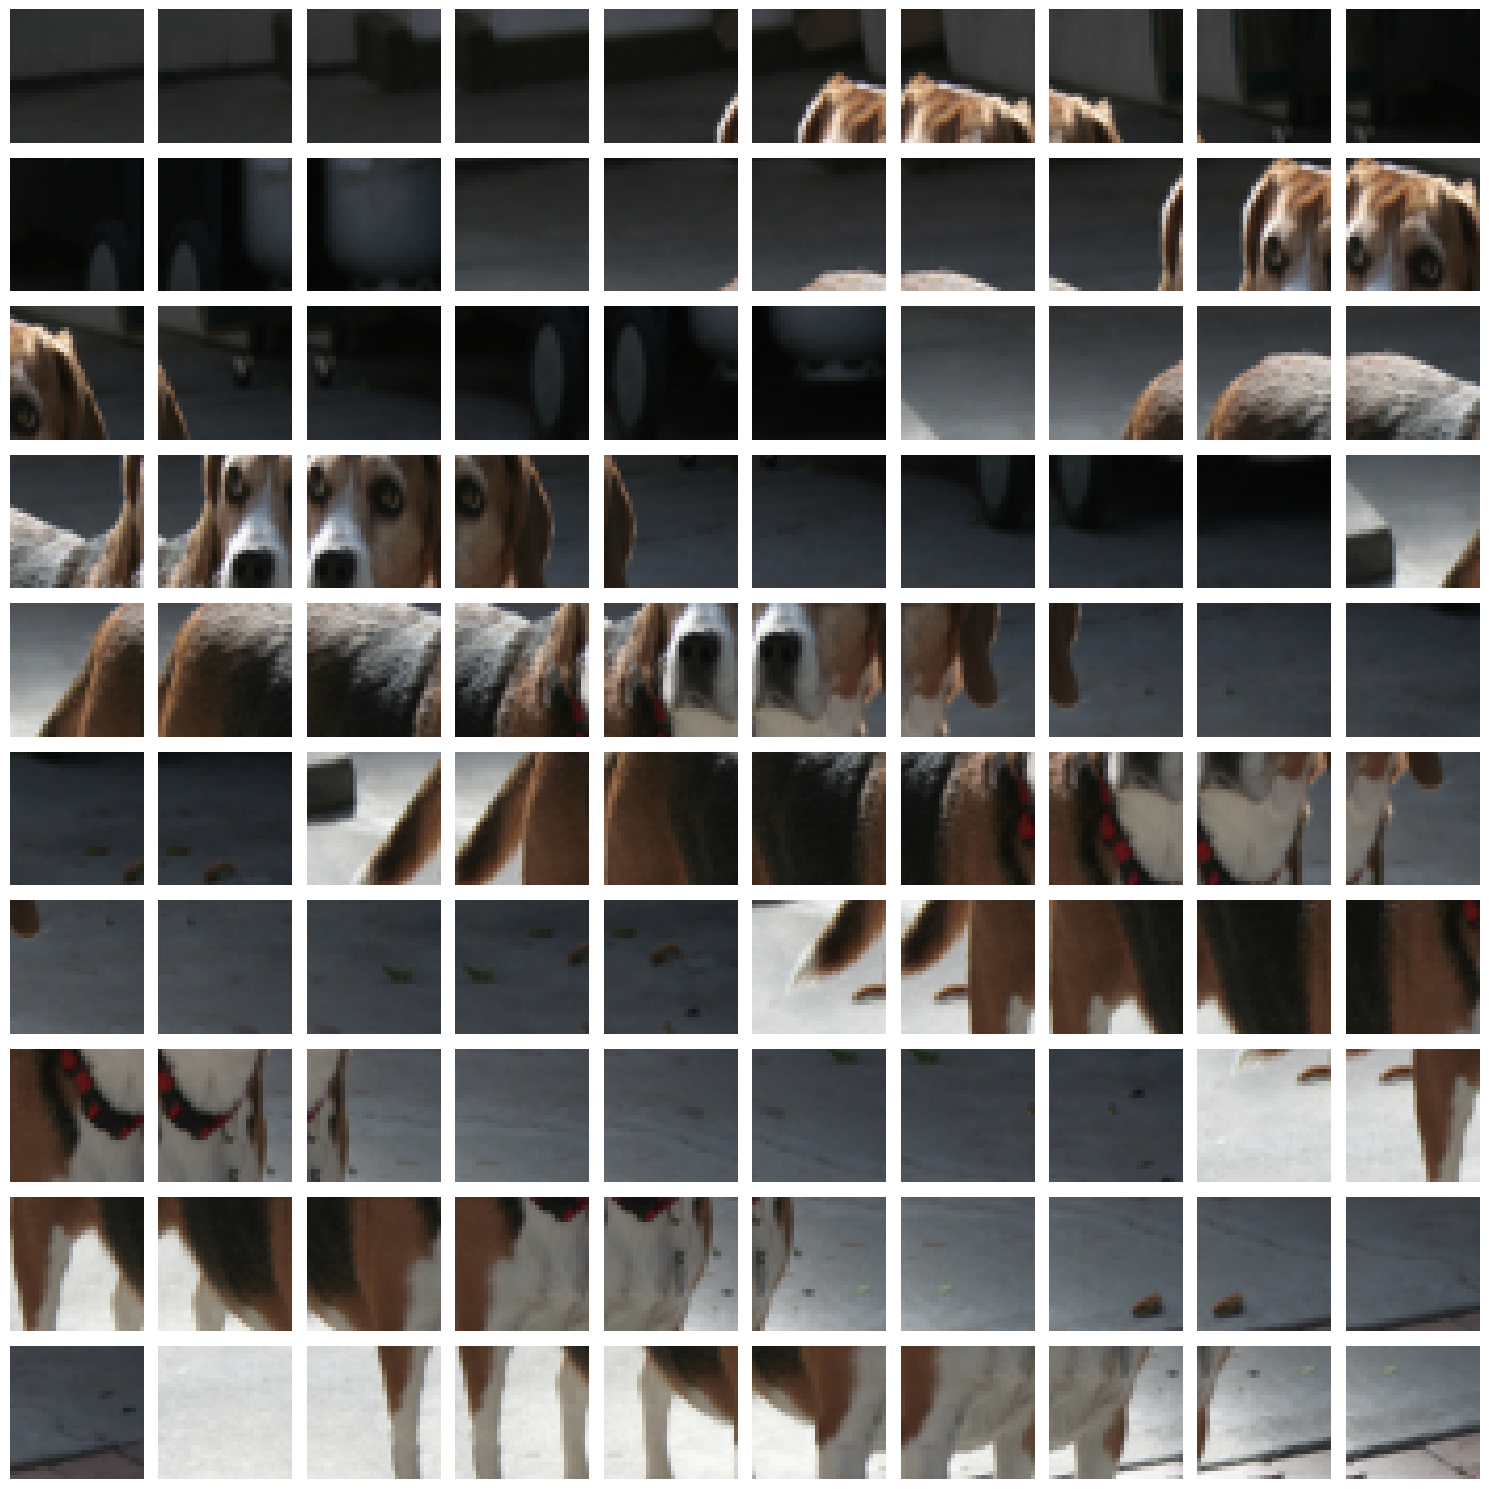

In [20]:
import math

# Calculate grid size for displaying all patches
num_patches = len(patches)
cols = 10  # Set the number of columns for the grid
rows = math.ceil(num_patches / cols)  # Calculate the necessary number of rows

# Display all patches in a grid
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.flatten()  # Flatten axes to simplify indexing

for i in range(rows * cols):
    if i < num_patches:
        axes[i].imshow(patches[i])
        axes[i].axis("off")
    else:
        axes[i].axis("off")  # Turn off axes for any extra subplot

plt.tight_layout()
plt.show()


Color augment patches

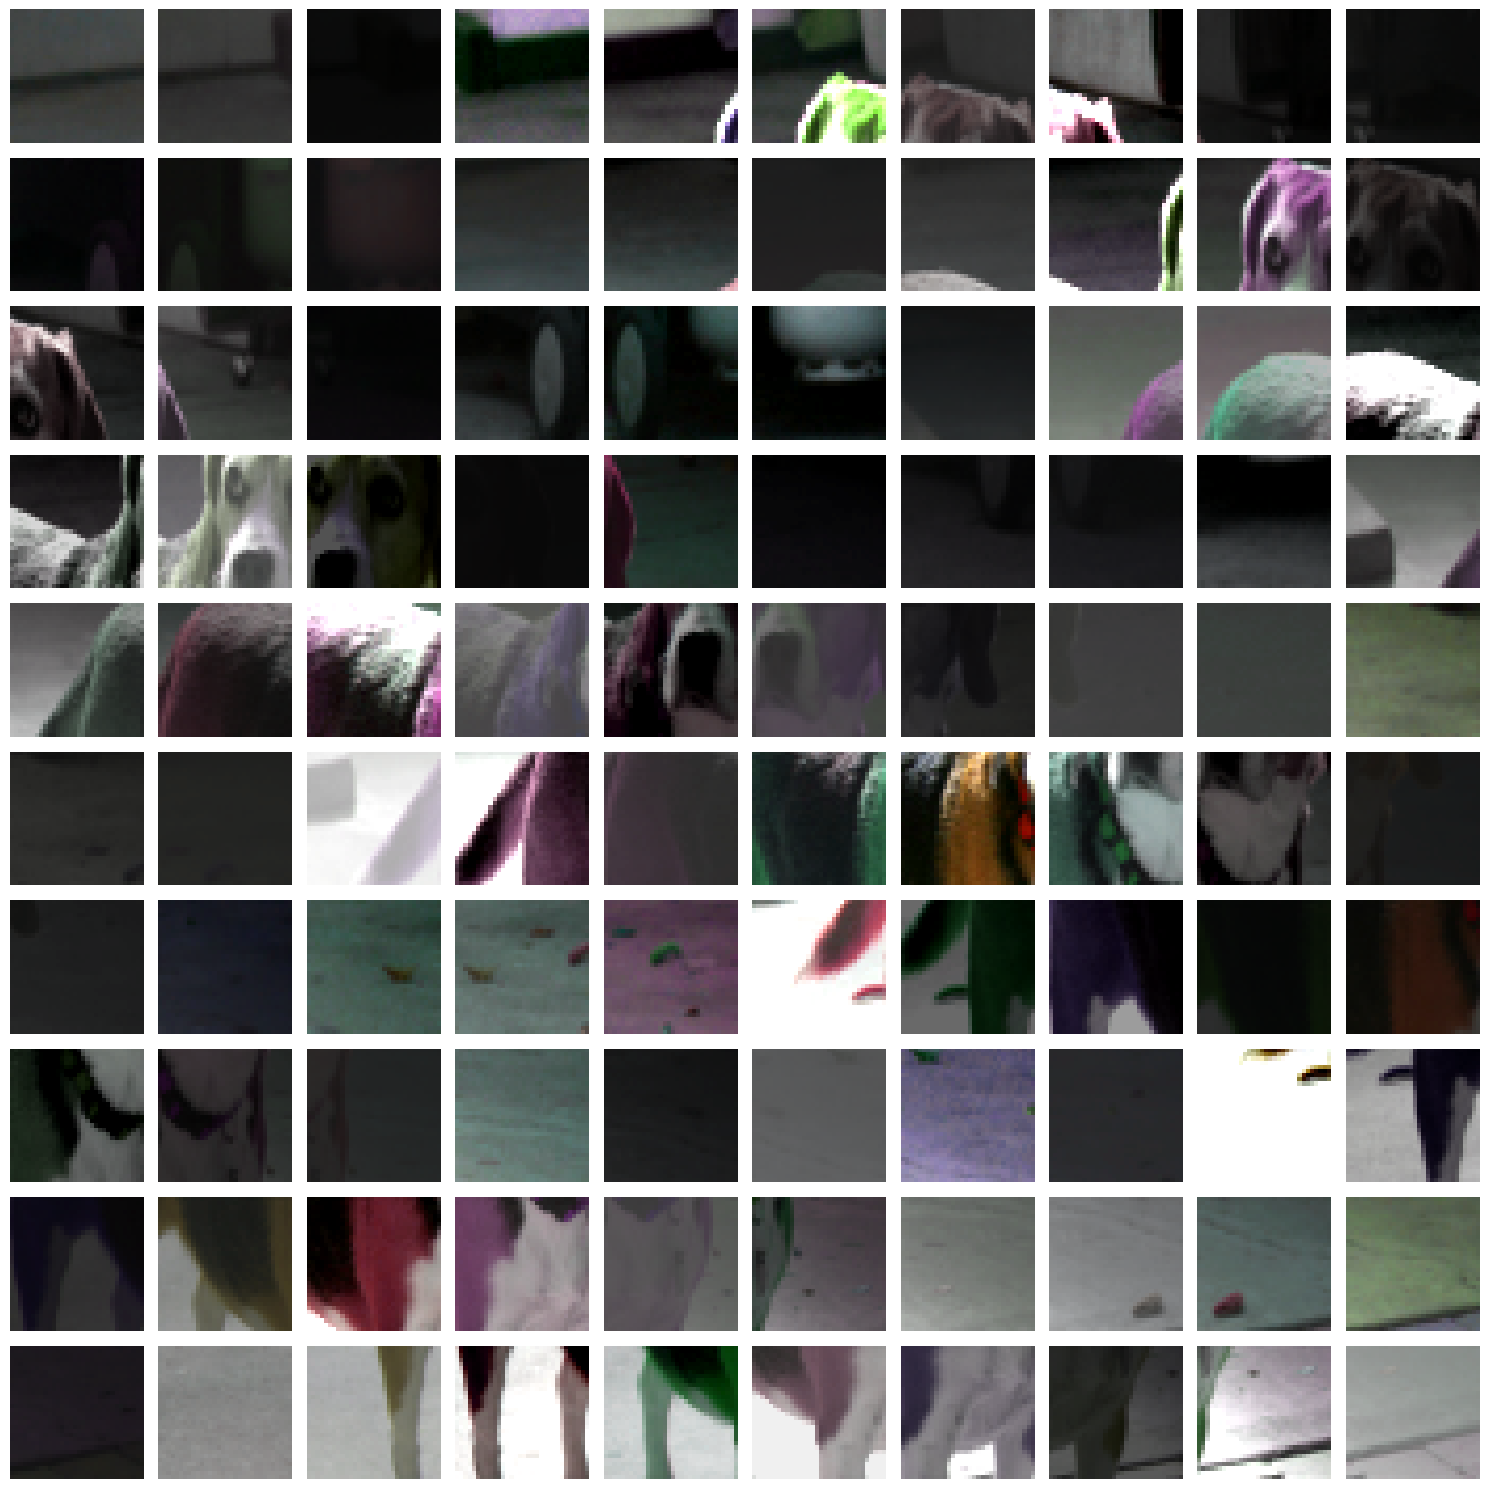

In [22]:


# Define a stronger color jitter transformation
color_jitter = transforms.ColorJitter(
    brightness=0.8,  # Increase brightness variation
    contrast=0.8,    # Increase contrast variation
    saturation=0.8,  # Increase saturation variation
    hue=0.4          # Increase hue variation
)

# Apply stronger color augmentation to each patch
augmented_patches = [color_jitter(patch) for patch in patches]

# Display the augmented patches in a grid
num_patches = len(augmented_patches)
cols = 10
rows = math.ceil(num_patches / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.flatten()

for i in range(rows * cols):
    if i < num_patches:
        axes[i].imshow(augmented_patches[i])
        axes[i].axis("off")
    else:
        axes[i].axis("off")

plt.tight_layout()
plt.show()


Embed the patches

In [26]:
# Load a pretrained ResNet model and remove the final classification layer
model = models.resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove the final layer
model.eval()  # Set the model to evaluation mode

# Define a transformation to resize patches to match ResNet's expected input size
resize_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to embed patches and keep track of their original positions
def embed_patches_with_positions(patches, positions):
    """Embeds patches and returns a list of tuples containing embeddings and positions."""
    embeddings_with_positions = []
    with torch.no_grad():  # Disable gradient computation
        for patch, position in zip(patches, positions):
            # Apply resize and normalization transformation
            patch_tensor = resize_transform(patch).unsqueeze(0)  # Add batch dimension
            embedding = model(patch_tensor)  # Pass through the model
            embeddings_with_positions.append((embedding.squeeze().numpy(), position))
    return embeddings_with_positions

# Extract the height and width of the original image tensor
_, height, width = image.shape  # assuming image is in (C, H, W) format

# Generate positions based on patch size and image dimensions
positions = [(y, x) for y in range(0, height, patch_size) for x in range(0, width, patch_size)]

# Apply color jitter to each patch
augmented_patches = [color_jitter(patch) for patch in patches]

# Embed patches and associate with positions
embeddings_with_positions = embed_patches_with_positions(augmented_patches, positions)

# Display the shape of the first embedding and its position to verify
print("Embedding and position:", embeddings_with_positions[0])  # Print one to check


/Users/shawheennaderi/programming_projects/yc_project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/shawheennaderi/programming_projects/yc_project_1/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Embedding and position: (array([5.18774316e-02, 0.00000000e+00, 3.30957095e-03, 6.13345683e-01,
       1.02621466e-01, 0.00000000e+00, 2.52398178e-02, 1.81066439e-01,
       5.27292751e-02, 1.71224563e-03, 2.87706465e-01, 6.33431086e-03,
       2.47637965e-02, 1.10255152e-01, 0.00000000e+00, 7.40427077e-02,
       0.00000000e+00, 3.66081089e-01, 1.64317325e-01, 3.61599843e-03,
       2.67860174e-01, 0.00000000e+00, 1.52132019e-01, 0.00000000e+00,
       1.48177654e-01, 2.37742122e-02, 2.20703762e-02, 3.75737995e-01,
       5.67653924e-02, 0.00000000e+00, 3.16554047e-02, 3.26182723e-01,
       8.54756124e-03, 1.85479503e-02, 5.26539143e-03, 0.00000000e+00,
       0.00000000e+00, 2.32328158e-02, 1.05551946e+00, 5.49495257e-02,
       0.00000000e+00, 0.00000000e+00, 5.74292475e-03, 7.56641757e-03,
       2.11924031e-01, 2.76172310e-02, 6.18671402e-02, 2.55704224e-02,
       0.00000000e+00, 0.00000000e+00, 1.47574451e-02, 9.63988807e-03,
       1.26687009e-02, 2.24971026e-02, 4.25490826e-0